In [231]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from ipynb.fs.full.datasetgenerator_sinewaves import create_dataset

In [232]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(1800, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Two outputs for mean and log variance
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1800),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        z_params = self.encoder(x)
        mu, logvar = z_params.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [233]:
# Hyperparameters
latent_dim = 32
batch_size = 100
learning_rate = 1e-3
epochs = 50

In [234]:
# Create the VAE model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [235]:
# Generate dataset using the provided function
number_of_generated_samples: int = 100000
number_of_survive_samples: int = 10000
selected_designs_masked, fitness_values = create_dataset(number_of_survive_samples, number_of_generated_samples)
data = torch.FloatTensor(selected_designs_masked).view(-1, 1800).to(device)  # Reshape to 1D tensor
data = data / 4.0
print(f" data: {data}")

 data: tensor([[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.2500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')


In [236]:
# Create DataLoader
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [237]:
# Training loop
losses = []
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')
    reconstruction_loss = BCE(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(f" kl_div: {kl_divergence} recon_loss: {reconstruction_loss}")
    return reconstruction_loss + kl_divergence

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        
    avg_loss = total_loss / len(dataset)
    losses.append(avg_loss)  # Store the average loss for this epoch
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss}")


Epoch [1/50] Loss: 768.0599484375
Epoch [2/50] Loss: 693.7845421875
Epoch [3/50] Loss: 687.8054328125
Epoch [4/50] Loss: 662.71886953125
Epoch [5/50] Loss: 645.20491171875
Epoch [6/50] Loss: 624.50965234375
Epoch [7/50] Loss: 599.15779453125
Epoch [8/50] Loss: 581.0396359375
Epoch [9/50] Loss: 549.53274765625
Epoch [10/50] Loss: 528.4550859375
Epoch [11/50] Loss: 501.1562453125
Epoch [12/50] Loss: 477.42136484375
Epoch [13/50] Loss: 450.917325
Epoch [14/50] Loss: 430.8202078125
Epoch [15/50] Loss: 412.0041921875
Epoch [16/50] Loss: 395.11879453125
Epoch [17/50] Loss: 377.7237484375
Epoch [18/50] Loss: 363.803983984375
Epoch [19/50] Loss: 353.629062890625
Epoch [20/50] Loss: 338.988326953125
Epoch [21/50] Loss: 329.5450484375
Epoch [22/50] Loss: 318.95280078125
Epoch [23/50] Loss: 310.188921875
Epoch [24/50] Loss: 301.389167578125
Epoch [25/50] Loss: 292.399067578125
Epoch [26/50] Loss: 283.6716125
Epoch [27/50] Loss: 277.336302734375
Epoch [28/50] Loss: 269.231788671875
Epoch [29/50] L

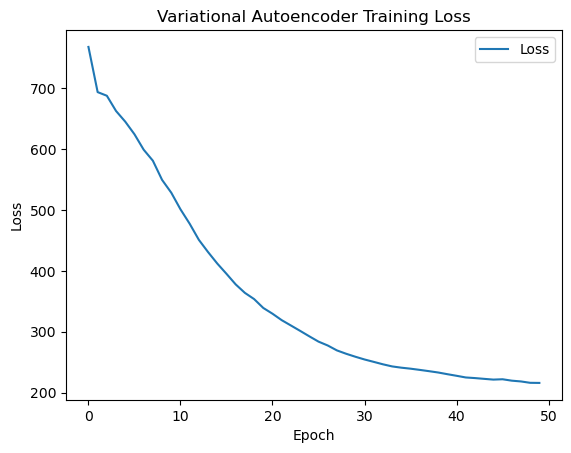

In [238]:
# Plot the loss curve
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Variational Autoencoder Training Loss')
plt.legend()
plt.show()

In [239]:
# Generate samples from the VAE
with torch.no_grad():
    z = torch.randn(number_of_survive_samples, latent_dim).to(device)
    generated_samples = model.decoder(z).cpu().view(-1, 30, 30)

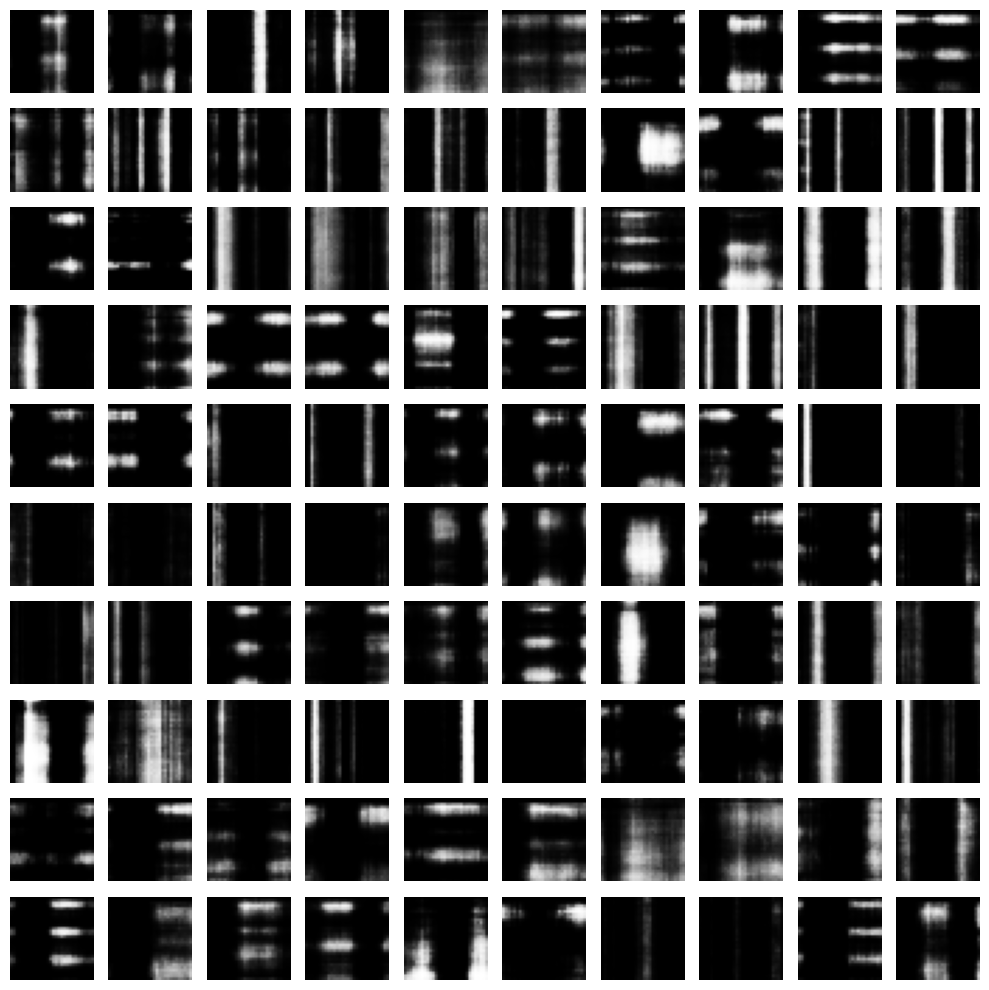

In [240]:
# Plot the generated samples
num_plots_per_axis = 10
fig, axs = plt.subplots(num_plots_per_axis, num_plots_per_axis, figsize=(10, 10))
for i in range(num_plots_per_axis):
    for j in range(num_plots_per_axis):
        axs[i, j].imshow(generated_samples[num_plots_per_axis * i + j], cmap='gray', vmin=0, vmax=1)
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()